# 자동차 연비 예측하기: 회귀

### Colab 에서 작성

*회귀*(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것입니다. 

이 노트북은 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터셋을 사용하여 1970년대 후반과 1980년대 초반에 생산된 자동차 연비를 예측하는 모델을 만듭니다. 이 기간에 출시된 자동차 정보를 모델에 제공합니다. 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense

## Auto MPG 데이터셋

- 이 데이터셋은 [UCI 머신 러닝 저장소](https://archive.ics.uci.edu/ml/)에서 다운로드할 수 있습니다.  


- Attribute Information:  
    1. mpg: 연비, 연속형 변수  
    2. cylinders: 이산형  
    3. displacement: 연속형  
    4. horsepower: 연속형  
    5. weight: 연속형  
    6. acceleration: 연속형  
    7. model year: 이산형  
    8. origin: 이산형 (1: USA, 2: Europe, 3: Japan)

### 데이터 download

In [2]:
dataset_path = tf.keras.utils.get_file("/content/auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/content/auto-mpg.data'

data를 읽어 DataFrame으로 만듭니다.

In [3]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                             'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values = "?", comment='\t',
                        sep=" ", skipinitialspace=True)

df = raw_dataset.copy()
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### 데이터 정제

이 데이터셋은 일부 데이터가 누락되어 있습니다.

In [4]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해서 missing value가 있는 행을 삭제합니다.

In [5]:
df = df.dropna()

`"Origin"` 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:  
1 - `USA`  
2 - `Europe`  
3 - `Japan`

In [6]:
df = pd.get_dummies(df, columns=["Origin"])
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


In [7]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.625000,0.173469,0.201531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.484742,0.379136,0.401656
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


### 데이터셋을 훈련 세트와 테스트 세트로 분할

In [8]:
X = df.drop('MPG', axis=1).values
y = df['MPG'].values
X.shape, y.shape

((392, 9), (392,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 9), (79, 9), (313,), (79,))

### 데이터 정규화
Standard Scaing : (X - mu) / sigma

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

## 모델

In [11]:
model = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


모델을 한번 실행해 봅니다. 훈련 세트에서 `10` 샘플을 하나의 배치로 만들어 `model.predict` 메서드를 호출하여 결과값이 예상대로 작성하는지 사전  check 합니다.

In [13]:
example_batch = X_train[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.32604858],
       [-0.08706263],
       [-0.36379924],
       [-0.23037924],
       [ 0.12351204],
       [ 1.0247359 ],
       [ 0.10495431],
       [ 0.16724642],
       [ 0.15143722],
       [ 0.37475932]], dtype=float32)

### 모델 훈련


In [14]:
EPOCHS = 1000  # early stop 할 것이므로 충분히 준다.

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=EPOCHS,
                     validation_split = 0.2, verbose=1, callbacks=[early_stop])

Epoch 1/500
8/8 [==============================] - 1s 38ms/step - loss: 581.8035 - mae: 22.8164 - mse: 581.8035 - val_loss: 594.9331 - val_mae: 22.8529 - val_mse: 594.9331
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 551.4221 - mae: 22.1250 - mse: 551.4221 - val_loss: 562.0459 - val_mae: 22.1298 - val_mse: 562.0459
Epoch 3/500
8/8 [==============================] - 0s 10ms/step - loss: 521.3904 - mae: 21.4275 - mse: 521.3904 - val_loss: 527.6730 - val_mae: 21.3494 - val_mse: 527.6730
Epoch 4/500
8/8 [==============================] - 0s 10ms/step - loss: 488.5605 - mae: 20.6573 - mse: 488.5605 - val_loss: 489.0389 - val_mae: 20.4546 - val_mse: 489.0389
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 452.3775 - mae: 19.7628 - mse: 452.3775 - val_loss: 447.5016 - val_mae: 19.4398 - val_mse: 447.5016
Epoch 6/500
8/8 [==============================] - 0s 9ms/step - loss: 413.4768 - mae: 18.7529 - mse: 413.4768 - val_loss: 403.2548 - val_mae:

`history` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화

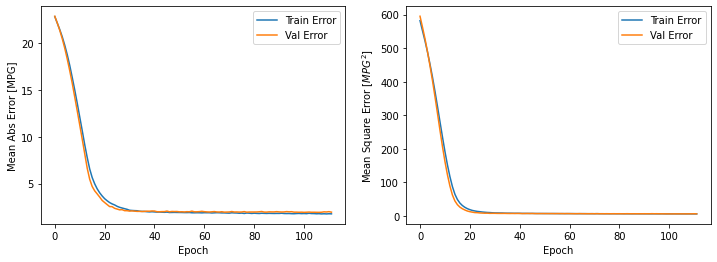

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train Error')
plt.plot(history.history['val_mae'], label = 'Val Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MPG]')

plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Train Error')
plt.plot(history.history['val_mse'], label = 'Val Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$MPG^2$]')
plt.show()

In [16]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.6921 - mae: 1.6863 - mse: 5.6921 - 29ms/epoch - 10ms/step
테스트 세트의 평균 절대 오차:  1.69 MPG


## 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

(8.27, 46.33, 8.27, 46.33)

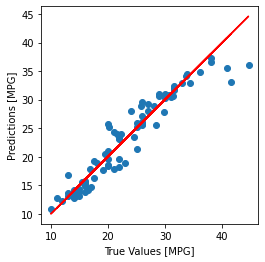

In [17]:
y_pred = model.predict(X_test).flatten()

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, c='r')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')